В качестве примера я решил реализовать три вариации DQN:
1. [DQN](https://arxiv.org/abs/1312.5602). 
2. [Double DQN](https://arxiv.org/pdf/1509.06461.pdf). 
3. [Dueling DQN](https://arxiv.org/pdf/1511.06581.pdf). 

Насколько мне известно, существует два основных подхода в Deep RL, на данный момент:
1. Policy optimization. Увеличиваем вероятность действий, приносящих положительные награды, и умеьшаем вероятность действий, приносящих отрицательные награды.
2. Q-learning. Изучаем value function, определяем оптимальные действия как действия с максимальным action value. 

### Q-learning. $\epsilon$-greedy, greedy policies. 
Все выбранные мною алгоритмы относятся к Q-learning. Они обучают action-value function, имея которую, мы в каждом состоянии можем сказать какое действие является оптимальным. Т.е. политика, в данном случае, присутствует неявно и это жадная политика. Однако, если обучать жадную политику напрямую, то найденное решение зачастую является неоптимальным (за исключением стационарных задач с вырожденными распределениями наград). 

Все потому, что агент быстро выбирает какое-то одно действие в каждом состоянии и, далее, продолжает выбирать его. Это действие может казаться локально оптимальным, но не быть таковым глобально. Для решения этой проблемы используется $\epsilon$-greedy политика. Суть этой политики заключается в том, что агент большую часть времени выбирает жадное действие, однако, иногда, с вероятностью $\epsilon$, он выбирает действие случайно, тем самым гарантирует исследование пространства состояний и действий. Теперь у агента есть надежда найти глобально оптимальное действие.

### Exploration / exploitation
Однако, если $\epsilon$ принимает значение близкое к 1, то агент только и занимается тем, что исследует пространство состояний и действий, не используя/эксплуатируя имеющуюся информацию об оптимальных действиях, тем самым, мы опять получаем неоптимальное поведение. Это так называемый exploration/exploitation trade-off.

К примеру, будем использовать константное значение $\epsilon$: 0.1 и 0.01. Тогда, в начале, первая политика найдет оптимальное действие быстрее, и ее средняя награда будет выше, однако, чуть позже, вторая политика также найдет оптимальное действие и в пределе будет имень среднюю награду выше, т.к. несмотря на то, что обе политики нашли оптимальные действия, первая политика все еще продолжает выбирать случайные действия 10% времени, а первая - только 1%.

Зная, что задача стационарна, можно пойти на ухищрение и сделать следующий трюк: вначале мы используем $\epsilon$, достаточное для того, чтобы гарантировать ислледование, а, далее, уменьшать $\epsilon$ линейно или экспоненциально с ростом количества шагов/действий агента. Тем самым, вначале агент будет активно исследовать, а ближе к концу обучения его политика станет жадной/почти жадной.

Также, мы можем помочь агенту в исследовании следующим образом: первые N шагов, агент выбирает действия абсолютно случайно, тем самым мы наполняем replay buffer полезными данными, которые мы используем для обучения агента в начале, когда веса value function далеки от оптимальных.

### DQNs
Теперь несколько слов об алгоритмах.

Коротко скажу, что все эти алгоритмы являются model-free (не используют модель среды), а также обучаются off-policy (используют данные полученные от другой политики, для обучения целевой).

**1. DQN.**
   
   В общем случае, off-policy + function approximation, использует следующий update:
   
   $$\theta_{t+1} = \theta_{t} + \alpha \left( R_{t+1} + \gamma Q(S_{t+1}, \hat a; \theta_t) - Q(S_t, A_t; \theta_t) \right) \nabla Q(S_t, A_t; \theta_t)$$
   
   где $\hat a$ - действие выбранное целевой политикой, $A_t$ - действие, выбранное исследовательской политикой, $\theta$ - параметры сети.
   
   Для Q-learning, в качестве целевой берут жадную, а в качестве исследовательской - $\epsilon$-greedy. И update сводится к:
  
   $$\theta_{t+1} = \theta_{t} + \alpha \left( R_{t+1} + \gamma \max_{a} Q(S_{t+1}, a; \theta_t) - Q(S_t, A_t; \theta_t) \right) \nabla Q(S_t, A_t; \theta_t)$$
   
   Эту конструкцию (target for the update) - $R_{t+1} + \gamma \max_{a} Q(S_{t+1}, a; \theta_t)$ - DQN использует в своей функции потерь.
   
   Также, для того, чтобы улучшить стабильность обучения нейросети, мы используем target network - копию основной нейросети, которую обновляем (в самом простом случае - копируем) каждые M шагов.
   
**2. Double DQN.**

Стоит отметить, что стандартный Q-learning склонен переоценивать ценность действий из-за того, что он вычисляет максимум по оценками. К примеру, пусть есть состояние, в котором присутствуют N действий, для каждого из которых существует распредение наград с мат. ожиданием равным нулю. Тогда, оптимальная action-value function в данном состоянии, для каждого действия принимает значение ноль. Однако, т.к. изначально нам не известны настоящие значения, то мы оцениваем их из данных, т.е. выбираем действия, совершаем их и получаем sample награды из соответствующего распределения. Тем самым, какие-то оценки будут иметь значение меньшее нуля, какие-то равное нулю, а какие-то большие нуля. Далее, мы берем максимум по этим оценкам и вполне вероятно получаем положительное число, хотя реальные оптимальные значение равны нулю. Это явление называется maximization bias.

Заметим, что явление само по себе нам не мешает: если все действия переоценены одинаково, то относительный порядок среди действий остается не измененным. Также, если все действия переоценены одинаково только в тех состояниях, которые нам интересны, а в других - произвольно, то данный расклад нас также устроит - агент не обязательно посетит все состояния, а в тех, которые он посетит относительный порядок сохранен. Но чаще переоценивание происходит в произвольном порядке и с этим надо как-то бороться.

Существует способ борьбы с этим явлением, который называется Double Q-learning, и данный алгоритм его использует.

Еще раз посмотрим на target для стандартного DQN: $R_{t+1} + \gamma \max_{a} Q(S_{t+1}, a; \theta_t)$и заметим, что мы выбираем и оцениваем действия одной и той же value function. 

Вместо этого, в статье предлагается разделить выбор и оценивание действия следующим образом:
1. Выбрать действие с помощью main value function (веса обучаются)
2. Оценить действие с помощью target value function (веса фиксированны)

В итоге имеем:
$R_{t+1} + \gamma Q_{target}(S_{t+1}, argmax_{a} Q_{main}(S_{t+1}, a; \theta^{main}_t); \theta^{target}_t)$

Согласно статье, данный подход позволяет уменьшить степень переоценивания, улучшить стабильность обучения. Благодаря тому, что политики менее переоценены, данный алгоритм может найти политики, которые лучше найденных стандартным DQN.

**3. Dueling DQN.**

##### **Данная архитектура не привязана к DQN, ее можно использовать для любого алгоритма**

Важным наблюдением является тот факт, что стандартный Q-learning оценивает ценность каждого действия отдельно. Существует такое понятие как advantage function: $A(s, a) = Q(s, a) - V(s)$. Заметим, что:

$$V(s) = E_a[Q(s, a)]$$

$$Q(s, a) = V(s) + A(s, a)$$

И, следовательно, $$E_a[A(s, a)] = E_a[Q(s, a) - V(s)] = V(s) - V(s) = 0$$

Advantage function показывает относительную ценность действия в состоянии. И основная идея статьи заключается в том, что мы можем разделить обучение $Q(s, a)$, на обучение $V(s)$ и $A(s, a)$. А, далее, получить $Q(s, a) = V(s) + A(s, a)$.

Т.е. сеть, вместо того, чтобы на выходе выдавать вектор значений Q, выдает одно значение - V, и вектор значений A, размерность которого совпадает с размерностью Q.

Казалось бы, результат тот же, а действий больше, в чем польза?
1. Вместо того, чтобы оценить ценность каждого действия в отдельности, мы можем оценить одно значение - V, а также оценить лишь добавки к V (advantage values), которые и дадут нам финальные значения Q. Оценить добавки проще, чем оценить значения напрямую.
2. В стандартном подходе мы много раз оцениваем одно и то же - все действия делят между собой одно и то же значение V, но мы для каждого конкретного действия оцениваем его отдельно.
3. Часто бывает так, что действия в каком-то состоянии имеют почти одинаковую ценность, потому что результат совершения любого из них изменяет состояние среды примерно одинаковым образом. И было бы странно пытаться оценить ценность каждого отдельно - много раз оценить почти одно и то же значение.

В итоге, при каждом обновлении ценности какого-то действия мы также обновляем значение V, тем самым оценка V получает больше информации и оцененное значение будет точнее, чем в стандартном подходе.

Хочу отметить, что в данной среде всего 3 действия, поэтому эффект применения данной архитектуры может быть не так заметен. С увеличением числа действий эффект проявляется сильнее.

### Технические детали
Замечу, что во всех выше указанных алгоритмах мы обновляем target сеть обычным копированием. Проблема данного подхода в том, что от момента копирования и до следующего копирования, релевантность весов уменьшается, а потом, после очередного копирования резко возрастает до исходного значения. В итоге, мы имеем пилообразный график. Альтернативным подходом является усреднение с помощью экспоненциального скользящего среднего. Плюсы:
1. Target сеть можно обновлять одновременно с main сетью. (избавляемся от скачков)
2. Вместо того, чтобы иметь одну копию сети, мы имеем "среднюю" сеть, взятую по скользящему окну.

Коротко о гиперпараметрах:
1. Replay buffer size. Т.к. мы выбираем данные случайным образом, то у каждого объекта вероятность быть выбранным равна $\frac{1}{N}$, N - размер replay buffer. Тогда:
    * При увеличении размера, вероятность произвольного объекта быть выбранным уменьшается, т.е. уменьшается эффективность данных (мы реже переиспользуем данные). Однако, условная "память" увеличивается, мы храним историю большего размера и агент может обучаться на большем количестве данных. Также, мы усредняем распределение данных по большому горизонту, тем самым уменьшая влияние нестационарности распределения на обучение.
    * При уменьшении размера, вероятность произвольного объекта быть выбранным увеличивается, т.е. увеличивается эффективность данных (мы чаще переиспользуем данные). Однако, условная "память" уменьшается, мы быстрее забываем историю и агент имеет меньшее количество данных для обучения. Влияние нестационарности на обучение увеличивается.
2. Как часто обновлять веса target сети. Мы фиксируем веса для того, чтобы процесс обучения был более стабильным.
    * Если мы обновляем веса часто, то стабильность ухудшается, зато веса больше похожи на веса основной сети.
    * Если мы обновляем веса слишком редко, то стабильность улучшается, но веса сильно отличаются от весов основной сети.
3. Start steps. Если это значение велико, то после стадии наполнения replay buffer данными, полученными от совершения случайных действий, агенту придется совершить большое количество шагов (зависит от размера buffer), чтобы перезаписать эти данные новым опытом. И пока он пытается, эти данные напрямую влияют на самого агента - мы их используем для его обучения. Поэтому значение данного параметра надо выбирать, учитывая размер buffer и специфику среды.
    
### Mountain Car environment
Коротко о среде:
1. Observation: [car position, car velocity]
2. Actions: 
    * 0 - accelerate to the left
    * 1 - don't accelerate
    * 2 - accelerate to the right
3. Reward:
    * 0 - если агент достиг флага (position = 0.5)
    * -1 - если position агента < 0.5
4. Termination:
    * Если position > 0.5
    * Длина эпизода > 200
   
   Отсюда следует, что нам не нужно явно контролировать длину эпизода, в любом случае его длина будет не больше 200.
5. Решение: как я понял, решением является агент, средняя награда которого за 100 эпизодов равна -110.

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
def ExponentialScheduler(start, end, T):
    def _inner(t):
        if t > T:
            return end
        return start * (end / start) ** (t / T)
    return _inner

def LinearScheduler(start, end, T):
    def _inner(t):
        if t > T: 
            return end
        return start  + (end - start) * (t / T)
    return _inner

Результат применения scheduler

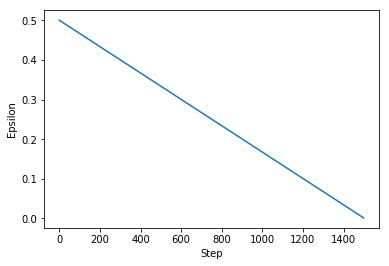

In [4]:
sched = LinearScheduler(0.5, 0.001, 1500)
eps = [sched(t) for t in range(1500)]

plt.plot(eps)
plt.xlabel("Step")
plt.ylabel("Epsilon")
plt.show()

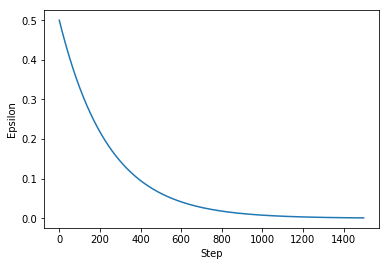

In [5]:
sched = ExponentialScheduler(0.5, 0.001, 1500)
eps = [sched(t) for t in range(1500)]

plt.plot(eps)
plt.xlabel("Step")
plt.ylabel("Epsilon")
plt.show()

In [82]:
def plot_results(rewards, max_q_values, loss, eps):
    rew100 = [np.mean(rewards[i:i + 100]) for i in range(0, len(rewards), 100)]
    
    for i in range(3):
        plt.figure(figsize=(15, 6))
        plt.plot(max_q_values[i], label = f"action {i}")
        plt.xlabel("Шаг")
        plt.ylabel("Q value")
        plt.legend()
        plt.show()
    
    plt.figure(figsize=(15, 6))
    plt.title("Средняя награда за 100 эпизодов")
    plt.plot(rew100)
    plt.xlabel("Эпизод")
    plt.ylabel("Средняя награда")
    plt.show()
    
    plt.figure(figsize=(15, 6))
    plt.title("График наград в эпизодах")
    plt.plot(rewards)
    plt.ylabel("Награда")
    plt.xlabel("Эпизод")
    plt.show()

    plt.figure(figsize=(15, 6))
    plt.plot(loss)
    plt.title("Функция потерь")
    plt.ylabel("Значение")
    plt.xlabel("Шаг")
    plt.show()

    plt.figure(figsize=(15, 6))
    plt.title("График эпсилон")
    plt.plot(eps)
    plt.ylabel("Эпсилон")
    plt.xlabel("Шаг")
    plt.show()

In [136]:
from main import DQN

Обучаем DQN

Episode: 100
	mean:-200.0             min: -200.0             max: -200.0
Episode: 200
	mean:-198.48             min: -200.0             max: -141.0
Episode: 300
	mean:-195.31             min: -200.0             max: -123.0
Episode: 400
	mean:-178.0             min: -200.0             max: -92.0
Episode: 500
	mean:-183.06             min: -200.0             max: -89.0
Episode: 600
	mean:-157.5             min: -200.0             max: -86.0
Episode: 700
	mean:-136.37             min: -200.0             max: -84.0
Episode: 800
	mean:-142.57             min: -200.0             max: -84.0
Episode: 900
	mean:-114.23             min: -200.0             max: -83.0
Episode: 1000
	mean:-103.67             min: -120.0             max: -83.0
Episode: 1100
	mean:-102.91             min: -169.0             max: -83.0
Episode: 1200
	mean:-105.45             min: -159.0             max: -84.0


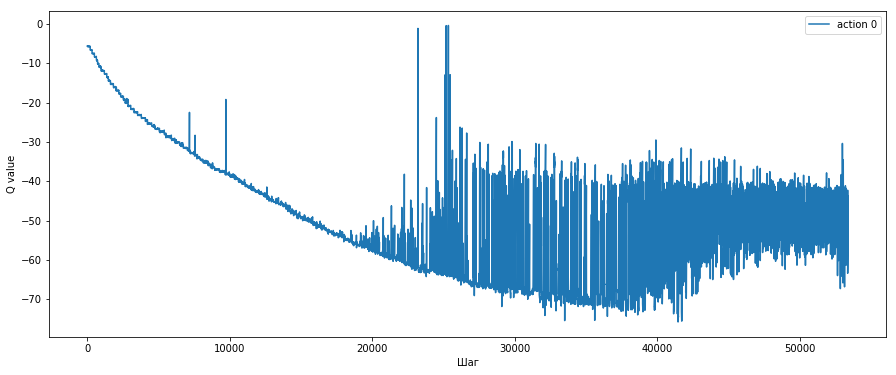

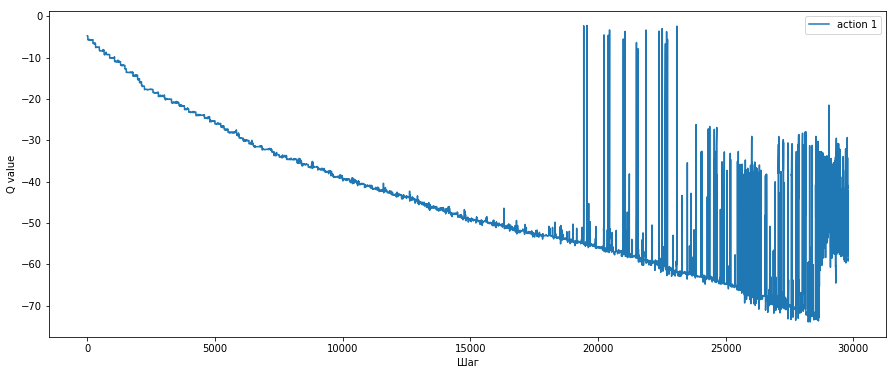

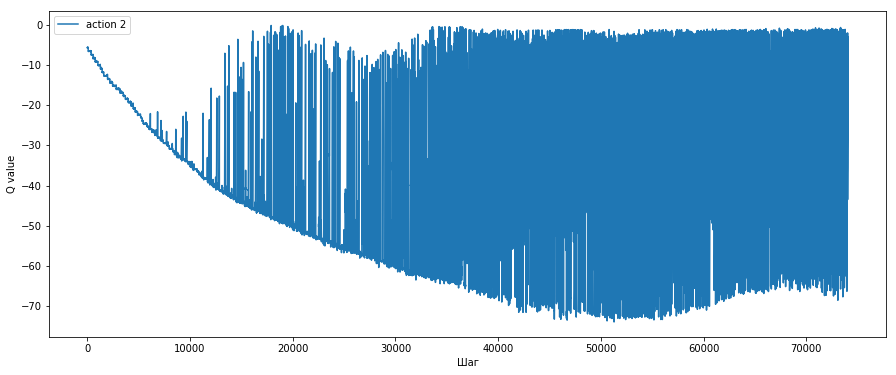

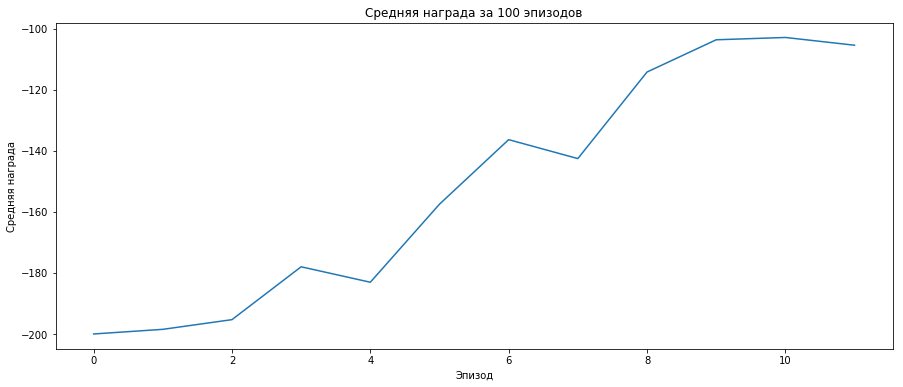

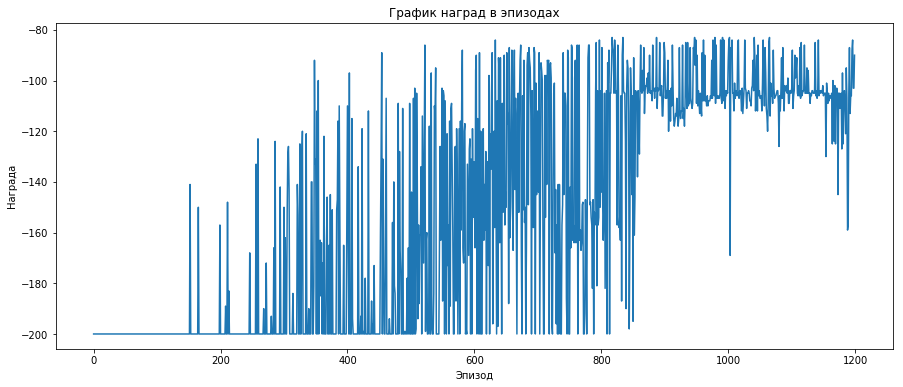

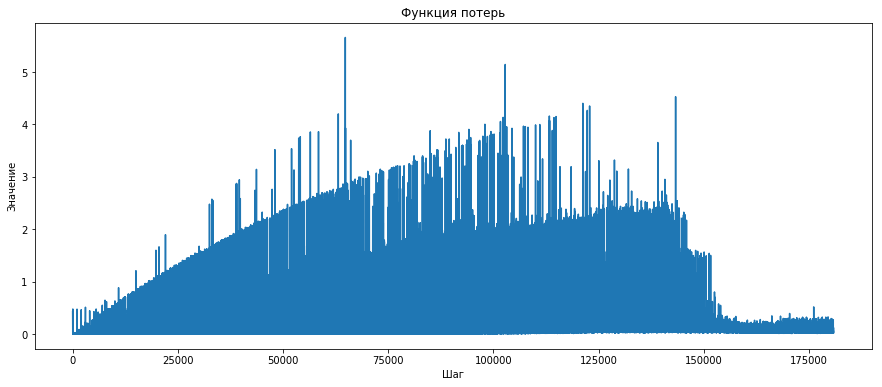

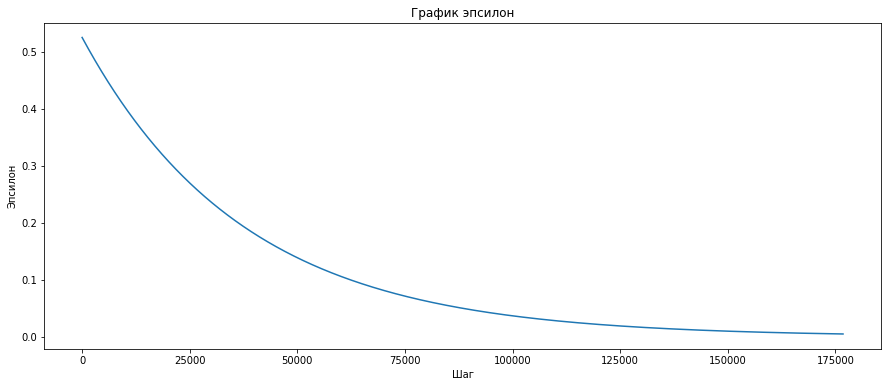

Wall time: 7min 45s


In [111]:
%%time
episodes = 1200
T = episodes * 200
scheduler = ExponentialScheduler(0.6, 0.001, T)
dqn_rewards, dqn_max_q_values, dqn_agent  = DQN("MountainCar-v0", 
                                                q_lr=1e-3,
                                                start_steps = 5000, 
                                                buffer_size = 15000, 
                                                batch_size = 32,
                                                update_target_every = 1000,
                                                n_filters = [128, 128],
                                                
                                                episodes = episodes, 
                                                gamma=0.99, 
                                                scheduler=scheduler,
                                                update_after = 1000, 
                                                update_every = 50, 
                                               )
plot_results(dqn_rewards, dqn_max_q_values, dqn_agent.loss_history, dqn_agent.eps_history)

Обучаем Double  DQN

Episode: 100
	mean:-200.0             min: -200.0             max: -200.0
Episode: 200
	mean:-199.99             min: -200.0             max: -199.0
Episode: 300
	mean:-199.29             min: -200.0             max: -149.0
Episode: 400
	mean:-188.12             min: -200.0             max: -109.0
Episode: 500
	mean:-172.24             min: -200.0             max: -90.0
Episode: 600
	mean:-164.84             min: -200.0             max: -84.0
Episode: 700
	mean:-145.11             min: -200.0             max: -84.0
Episode: 800
	mean:-140.08             min: -200.0             max: -83.0
Episode: 900
	mean:-119.19             min: -200.0             max: -83.0
Episode: 1000
	mean:-104.64             min: -200.0             max: -83.0
Episode: 1100
	mean:-103.42             min: -166.0             max: -84.0
Episode: 1200
	mean:-101.21             min: -173.0             max: -83.0


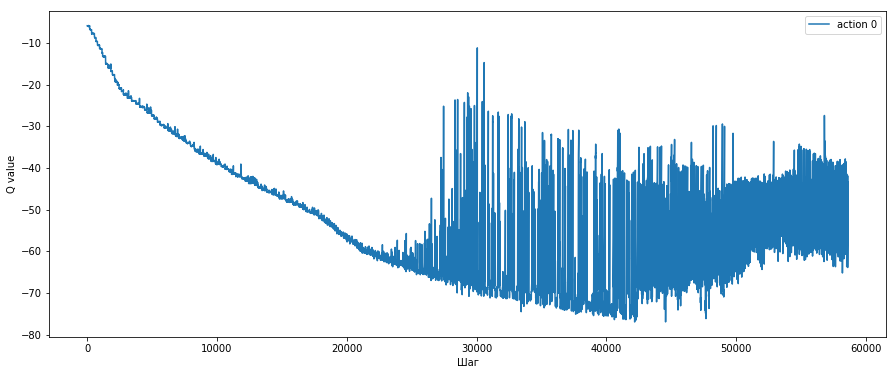

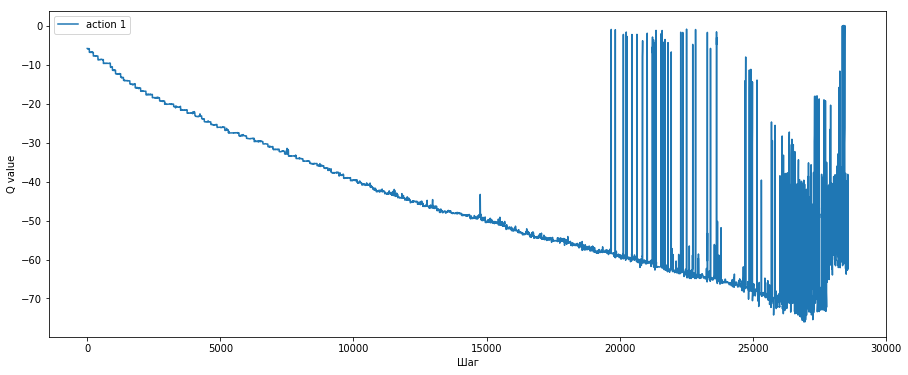

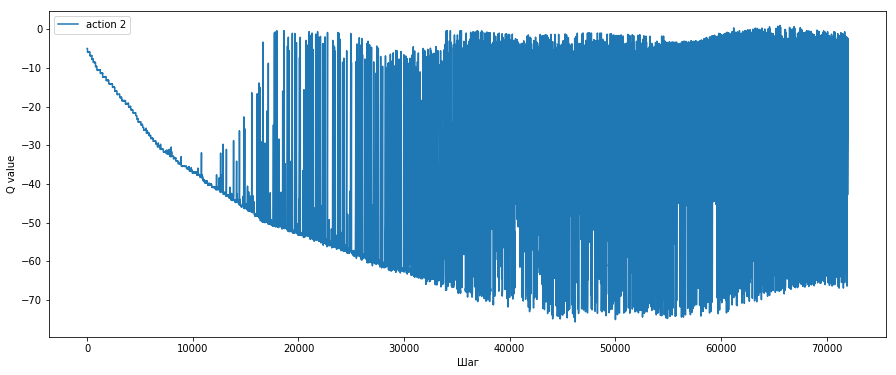

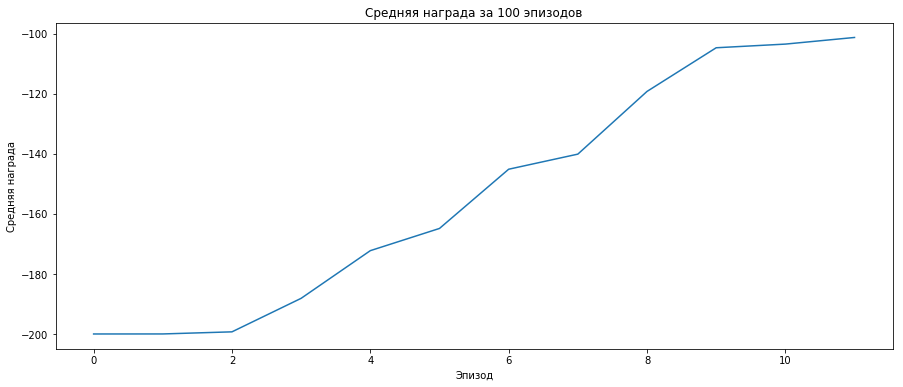

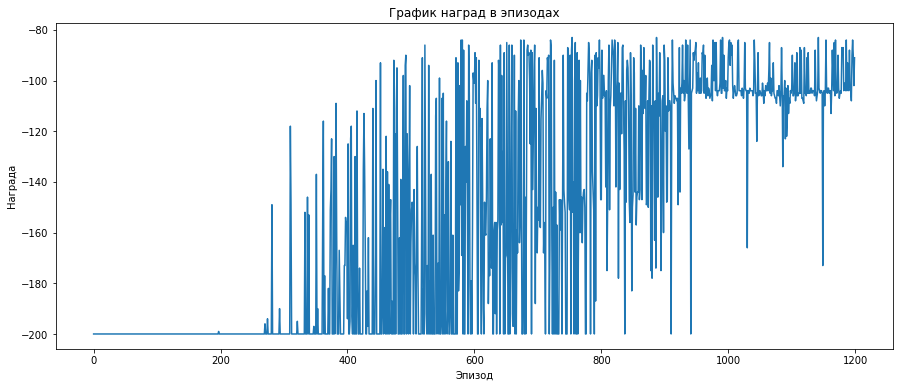

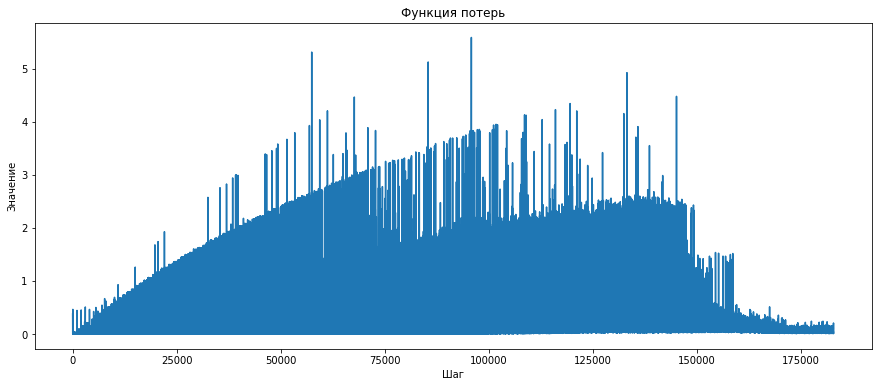

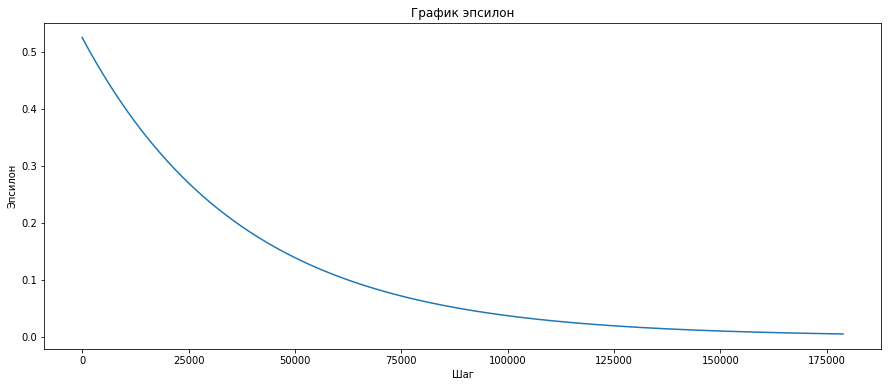

Wall time: 9min 3s


In [97]:
%%time
episodes = 1200
T = episodes * 200
scheduler = ExponentialScheduler(0.6, 0.001, T)
double_rewards, double_max_q_values, double_agent  = DQN("MountainCar-v0", 
                                                q_lr=1e-3,
                                                start_steps = 5000, 
                                                buffer_size = 15000, 
                                                batch_size = 32,
                                                update_target_every = 1000,
                                                n_filters = [128, 128],
                                                double = True,
                                                
                                                episodes = episodes, 
                                                gamma=0.99, 
                                                scheduler=scheduler,
                                                update_after = 1000, 
                                                update_every = 50, 
                                               )
plot_results(double_rewards, double_max_q_values, double_agent.loss_history, double_agent.eps_history)

Обучаем Dueling DQN

Episode: 100
	mean:-200.0             min: -200.0             max: -200.0
Episode: 200
	mean:-199.37             min: -200.0             max: -142.0
Episode: 300
	mean:-198.55             min: -200.0             max: -151.0
Episode: 400
	mean:-198.86             min: -200.0             max: -154.0
Episode: 500
	mean:-182.55             min: -200.0             max: -86.0
Episode: 600
	mean:-182.03             min: -200.0             max: -86.0
Episode: 700
	mean:-142.36             min: -200.0             max: -84.0
Episode: 800
	mean:-137.75             min: -200.0             max: -84.0
Episode: 900
	mean:-133.54             min: -200.0             max: -86.0
Episode: 1000
	mean:-128.38             min: -200.0             max: -83.0
Episode: 1100
	mean:-130.04             min: -200.0             max: -83.0
Episode: 1200
	mean:-126.73             min: -200.0             max: -84.0


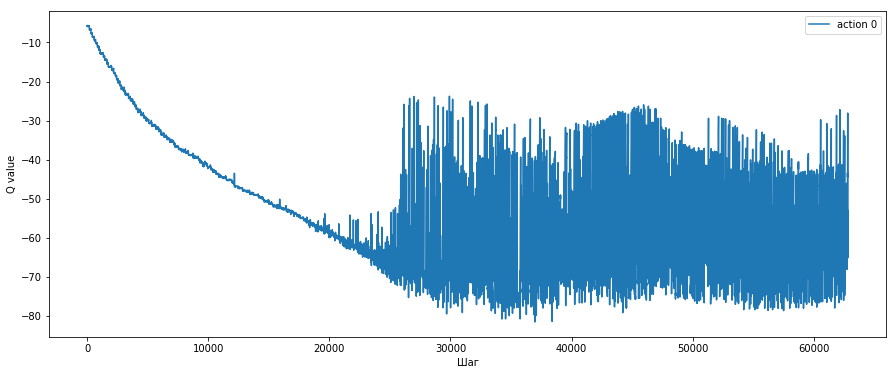

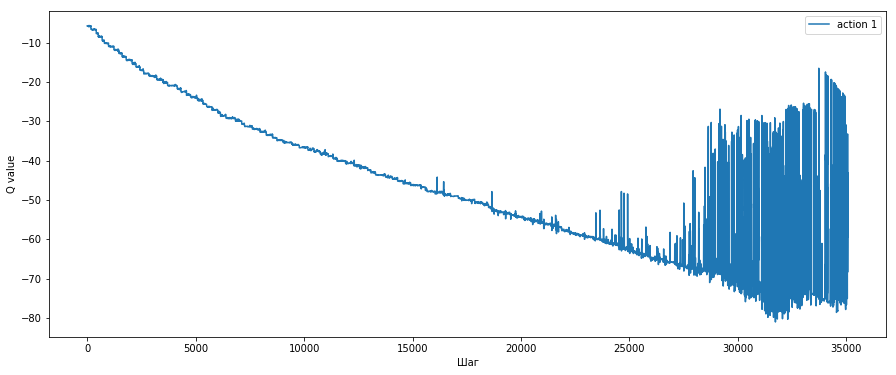

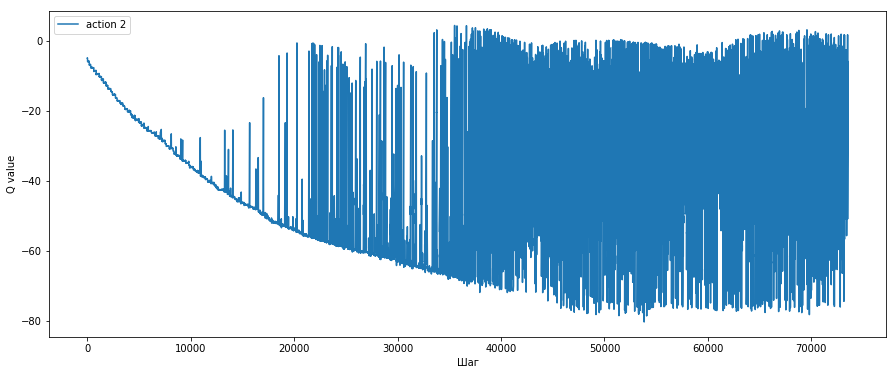

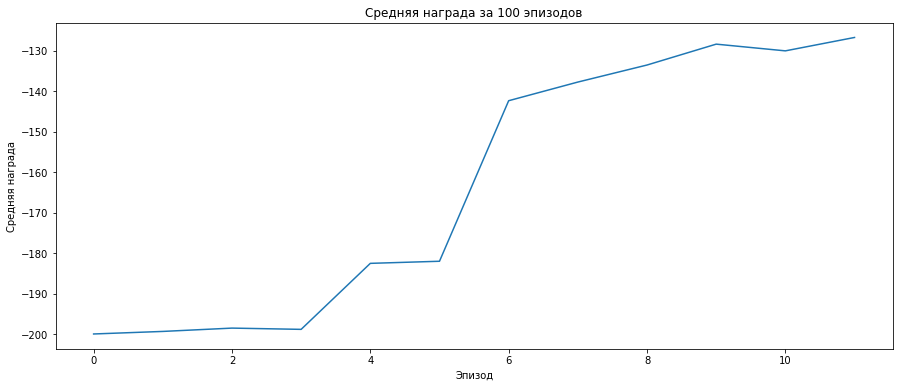

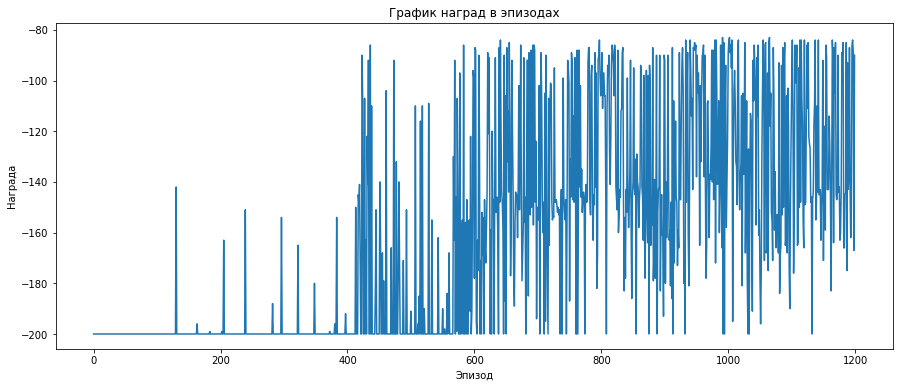

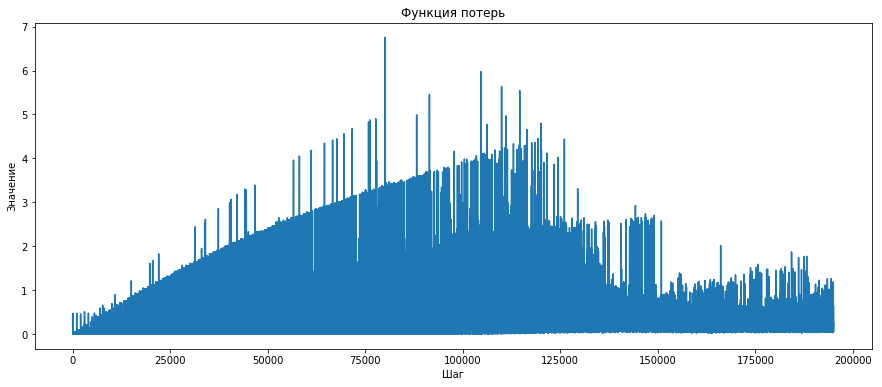

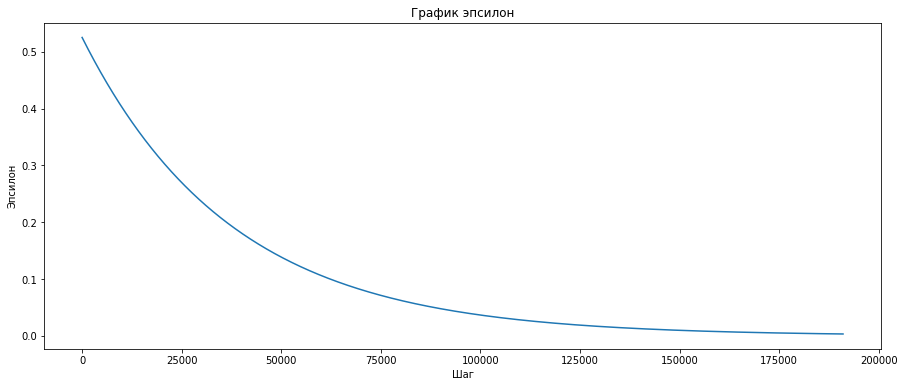

Wall time: 14min 41s


In [102]:
%%time
episodes = 1200
T = episodes * 200
scheduler = ExponentialScheduler(0.6, 0.001, T)
dueling_rewards, dueling_max_q_values, dueling_agent  = DQN("MountainCar-v0", 
                                                q_lr=1e-3,
                                                start_steps = 5000, 
                                                buffer_size = 15000, 
                                                batch_size = 32,
                                                update_target_every = 1000,
                                                n_filters = [128, 128],
                                                double = True,
                                                dueling = True,
                                                
                                                episodes = episodes, 
                                                gamma=0.99, 
                                                scheduler=scheduler,
                                                update_after = 1000, 
                                                update_every = 50, 
                                               )
plot_results(dueling_rewards, dueling_max_q_values, dueling_agent.loss_history, dueling_agent.eps_history)

Посмотрим на результаты

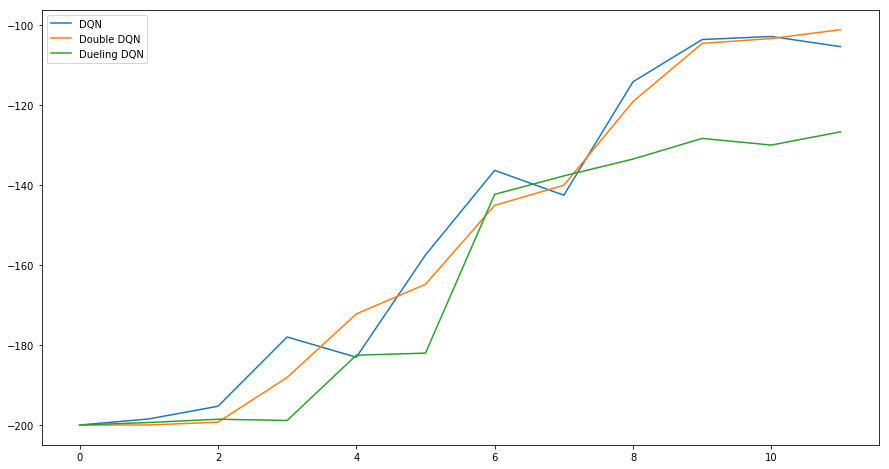

In [124]:
def get_mean(data, window = 100):
    return [np.mean(data[i:i + window]) for i in range(0, len(data), window)]

plt.figure(figsize=(15, 8))
plt.plot(get_mean(dqn_rewards), label="DQN")
plt.plot(get_mean(double_rewards), label="Double DQN")
plt.plot(get_mean(dueling_rewards), label="Dueling DQN")
plt.legend()
plt.show()

Исходя из графика выше, можно заметить, что для DQN средняя награда за 100 эпизодов начала возрастать быстрее остальных, но ее график содержит скачки и спады. В то время как для Double DQN рост почти линейный лишь с небольшими отклонениями.

Т.к. в данной среде всего 3 действия, то сильного вклада от применения Dueling архитектуры ожидать не приходится. Как можно заметить из графика выше, алгоритм смог добиться только средней награды в примерно -120. Польза от использование Double DQN чуть более заметна - качество поведения агента улучшается более стабильно.

Можно посмотреть на график среднего значения функции потерь, взятого в окнце по 2000 шагов (примерно 10 эпизодов)

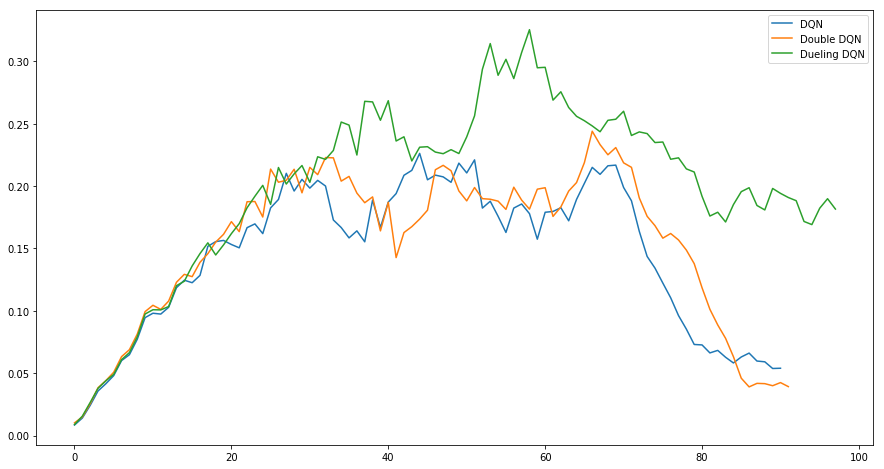

In [133]:
plt.figure(figsize=(15, 8))
plt.plot(get_mean(dqn_agent.loss_history, window = 2000), label ="DQN")
plt.plot(get_mean(double_agent.loss_history, window = 2000), label ="Double DQN")
plt.plot(get_mean(dueling_agent.loss_history, window = 2000), label ="Dueling DQN")
plt.legend()
plt.show()

Можно заметить, что потеря для Dueling DQN сильно больше, чем у остальных. Под конце обучения, потеря у Double DQN чуть меньше, чем у DQN.

Посмотрим на график среднего максимального Q value, взятого в окне по 1000 шагов, для каждого действия

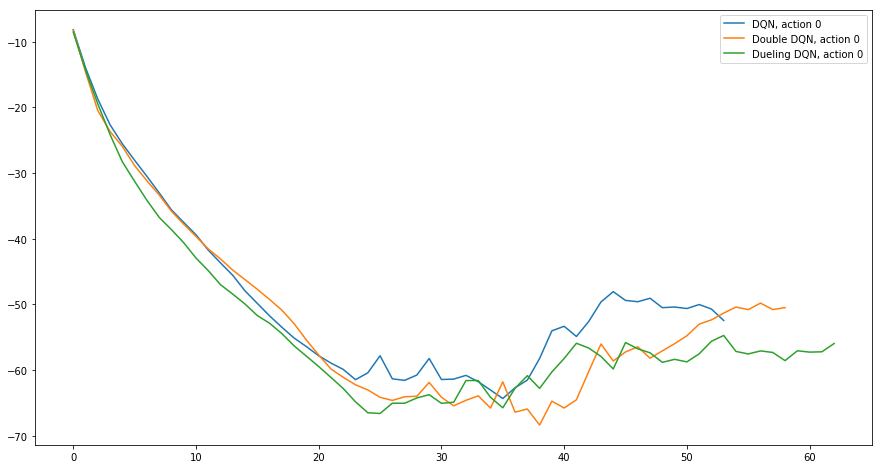

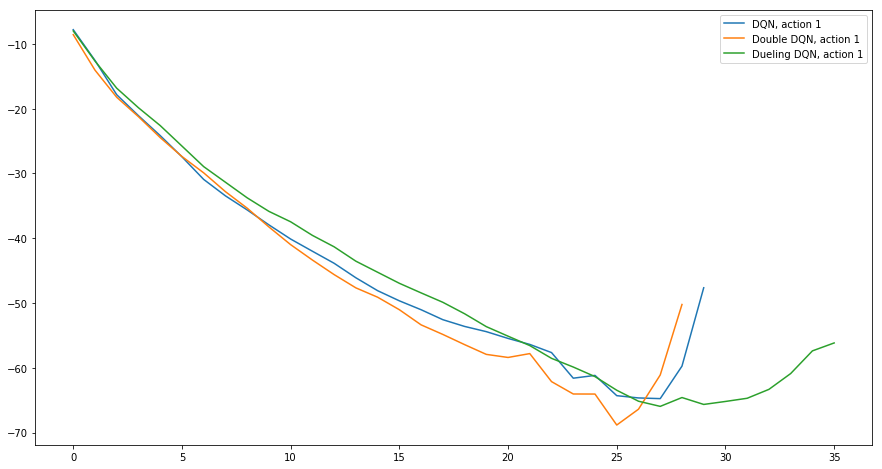

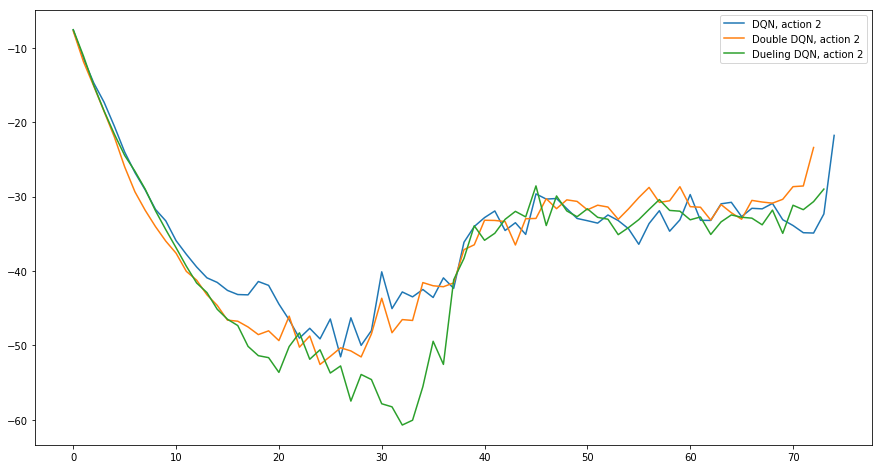

In [135]:
for i in range(3):
    plt.figure(figsize=(15, 8))
    plt.plot(get_mean(dqn_max_q_values[i], window = 1000), label =f"DQN, action {i}")
    plt.plot(get_mean(double_max_q_values[i], window = 1000), label =f"Double DQN, action {i}")
    plt.plot(get_mean(dueling_max_q_values[i], window = 1000), label =f"Dueling DQN, action {i}")
    plt.legend()
    plt.show()